### Import models and load data

In [48]:
from torchvision import datasets
import torch
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

# Import all models
from BaseNet import *
from ConvNet1 import *
#from NetSharing import *

mini_batch_size = 1000
nb_epochs = 300
nb_runs = 2
eta = 0.001

train_input, train_target, train_classes, test_input, test_target, test_classes = \
    prologue.generate_pair_sets(nb=1000)

/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### 1channel2images

In [2]:
from importlib import reload
import _1channel2images
reload(_1channel2images)
from _1channel2images import *

print("Working with 1channel2images framework, nb_classes = ", nb_classes)

#model = BaseNet1C(nb_classes)
model_1C = ConvNet1_1C(nb_classes)
optimizer_1C = torch.optim.SGD(model_1C.parameters(), lr=eta, momentum=0.95)
test_results_1C = multiple_training_runs(model_1C, 2, optimizer_1C, train_input, train_classes,
                                      test_input, test_target, test_classes, mini_batch_size, nb_epochs)
write_to_csv('1channel2images.csv', model_1C, test_results_1C)

Working with 1channel2images framework, nb_classes =  10


KeyboardInterrupt: 

In [ ]:
# This is just for visualization of our results but it will have to be taken away for the report 
# since we can't use any additional libraries
import pandas as pd

print(test_results_1C)
write_to_csv('1channel2images.csv', model_1C, test_results_1C)
data = pd.read_csv('1channel2images.csv')
data.head()

### 2channels1image

In [ ]:
import _2channels1image
reload(_2channels1image)
from _2channels1image import *

print("Working with 2channels1image framework, nb_classes = ", nb_classes)

model_2C = ConvNet1_2C(nb_classes)
optimizer_2C = torch.optim.SGD(model_2C.parameters(), lr=0.00001, momentum=0.95)  
test_results_2C = multiple_training_runs(model_2C, 2, optimizer_2C, train_input, train_target,
                           test_input, test_target, mini_batch_size, nb_epochs)
write_to_csv('2channels1image.csv', model_2C, test_results_2C)

In [ ]:
print(test_results_2C)
write_to_csv('2channels1image.csv', model_2C, test_results_2C)
data = pd.read_csv('2channels1image.csv')
data.head()

### Weight Sharing

In [ ]:
import weight_sharing
reload(weight_sharing)
from weight_sharing import *

print("Working with weight_sharing framework")

model_ws = NetSharing1()
optimizer_ws = torch.optim.SGD(model_ws.parameters(), lr=0.00001, momentum=0.95)  
test_results_ws = multiple_training_runs(model_ws, nb_runs, optimizer_ws, train_input, train_target,
                           test_input, test_target, mini_batch_size, nb_epochs)
write_to_csv('weightsharing.csv', model_ws, test_results_ws)

In [ ]:
print(test_results_ws)
write_to_csv('weightsharing.csv', model_ws, test_results_ws)
data = pd.read_csv('weightsharing.csv')
data.head()

### Auxiliary Losses

In [ ]:
import auxiliary_losses
reload(auxiliary_losses)
from auxiliary_losses import *
import Incept1
reload(Incept1)
from Incept1 import *
nb_epochs = 300
print("Working with auxiliary losses framework")

model_aux = Incept1()
optimizer_aux = torch.optim.SGD(model_aux.parameters(), lr=0.00001, momentum=0.95)  
test_results_aux = multiple_training_runs(model_aux, nb_runs, optimizer_aux, train_input, train_target, train_classes, 
                                          test_input, test_target, test_classes, mini_batch_size, nb_epochs)
write_to_csv('auxiliary_losses.csv', model_aux, test_results_aux)

In [ ]:
print(test_results_aux)
write_to_csv('auxiliary_losses.csv', model_aux, test_results_aux)
data = pd.read_csv('auxiliary_losses.csv')
data.head()

### Weight Sharing Model (Youssef)

In [49]:
print(train_input.shape, train_target.shape, train_classes.shape, test_input.shape, test_target.shape, test_classes.shape)

torch.Size([1000, 2, 14, 14]) torch.Size([1000]) torch.Size([1000, 2]) torch.Size([1000, 2, 14, 14]) torch.Size([1000]) torch.Size([1000, 2])


In [50]:
from torch.autograd import Variable
from WSharingModel import *
from torch import nn, optim
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss

#### Function that draws the evolution of the loss during training.

In [64]:
def visualize_loss(model,loss_model,lr):
    plt.plot(loss_model[0],loss_model[1], color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Evolution of the loss during training with learning rate {:>5} of the model {:>5}.'.format(lr,model.__class__.__name__))
    plt.show()

#### Function that prints the results of the prediction one the model is trained.

In [85]:
def print_results(model,optimizer,learning_rate,NB_EPOCHS,MINI_BATCH_SIZE, train_input, train_target,test_input, test_target):
     print('model: {:6}, optimizer: {:6}, learning rate: {:6}, num epochs: {:3}, '
                    'mini batch size: {:3}, train error: {:5.2f}%, test error: {:5.2f}%'.format(
                    model.__class__.__name__,
                    optimizer.__name__,
                    learning_rate,
                    NB_EPOCHS,
                    MINI_BATCH_SIZE,
                    compute_nb_errors(model, train_input, train_target, MINI_BATCH_SIZE) / train_input.size(0) * 100,
                    compute_nb_errors(model, test_input, test_target, MINI_BATCH_SIZE) / test_input.size(0) * 100
                    )
                )

In [53]:
# normalize it
mean, std = train_input.mean(), train_input.std() 
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable(train_classes)
test_input, test_target = Variable(test_input), Variable(test_target)

In [80]:
NB_EPOCHS = 50
MINI_BATCH_SIZE = 100
learning_rates = [0.1, 0.01]
models = [WSModel(),WSModel1()] ## Weight Sharing model with main architecture.

In [81]:
op = torch.optim.SGD

In [82]:
optimizer = op(model.parameters(),lr = learning_rates[0])

In [83]:
losses = [CrossEntropyLoss(),BCEWithLogitsLoss()]

#### Training of the WSModel and Results on Training and Testing set.

Loss at   0 : 1.4503130912780762  
Loss at   1 : 1.3649001121520996  
Loss at   2 : 0.8515456318855286  
Loss at   3 : 0.8982586860656738  
Loss at   4 : 0.9027402997016907  
Loss at   5 : 0.8521204590797424  
Loss at   6 : 0.8425348401069641  
Loss at   7 : 0.833523154258728  
Loss at   8 : 0.7985590100288391  
Loss at   9 : 0.642433226108551  
Loss at  10 : 0.5415620803833008  
Loss at  11 : 0.6354197859764099  
Loss at  12 : 0.4558788239955902  
Loss at  13 : 0.4515688419342041  
Loss at  14 : 0.40451133251190186  
Loss at  15 : 0.39111587405204773  
Loss at  16 : 0.3473049998283386  
Loss at  17 : 0.33056727051734924  
Loss at  18 : 0.30584603548049927  
Loss at  19 : 0.2799692451953888  
Loss at  20 : 0.25303348898887634  
Loss at  21 : 0.23446853458881378  
Loss at  22 : 0.21057389676570892  
Loss at  23 : 0.18702103197574615  
Loss at  24 : 0.16925905644893646  
Loss at  25 : 0.14625366032123566  
Loss at  26 : 0.18255171179771423  
Loss at  27 : 0.1350538581609726  
Loss at  28

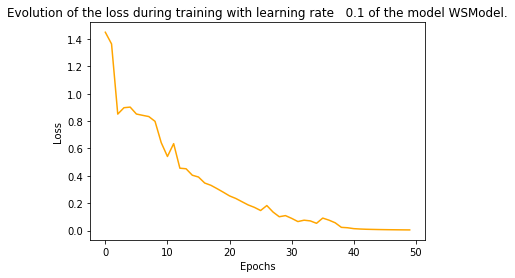

Loss at   0 : 1.1168984174728394  
Loss at   1 : 0.7525196075439453  
Loss at   2 : 0.71271812915802  
Loss at   3 : 0.6974772810935974  
Loss at   4 : 0.6875201463699341  
Loss at   5 : 0.6790728569030762  
Loss at   6 : 0.672258734703064  
Loss at   7 : 0.666492760181427  
Loss at   8 : 0.6639107465744019  
Loss at   9 : 0.6612750887870789  
Loss at  10 : 0.6573432087898254  
Loss at  11 : 0.6506713032722473  
Loss at  12 : 0.6421377658843994  
Loss at  13 : 0.632201075553894  
Loss at  14 : 0.6217300295829773  
Loss at  15 : 0.6114012002944946  
Loss at  16 : 0.6010339856147766  
Loss at  17 : 0.5908440947532654  
Loss at  18 : 0.5801240801811218  
Loss at  19 : 0.5696746110916138  
Loss at  20 : 0.5593605637550354  
Loss at  21 : 0.549363911151886  
Loss at  22 : 0.5396305322647095  
Loss at  23 : 0.5305519700050354  
Loss at  24 : 0.5216701030731201  
Loss at  25 : 0.5134097933769226  
Loss at  26 : 0.5056833028793335  
Loss at  27 : 0.498221218585968  
Loss at  28 : 0.49107879400

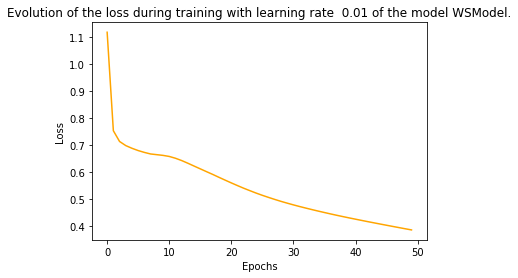

Loss at   0 : 2.2612547874450684  
Loss at   1 : 2.107112169265747  
Loss at   2 : 1.9507734775543213  
Loss at   3 : 1.7895129919052124  
Loss at   4 : 1.6271107196807861  
Loss at   5 : 1.4680938720703125  
Loss at   6 : 1.3173377513885498  
Loss at   7 : 1.1859283447265625  
Loss at   8 : 1.0784271955490112  
Loss at   9 : 0.9933074116706848  
Loss at  10 : 0.9274842739105225  
Loss at  11 : 0.8776654005050659  
Loss at  12 : 0.8404647707939148  
Loss at  13 : 0.8126304745674133  
Loss at  14 : 0.7915626764297485  
Loss at  15 : 0.7753748893737793  
Loss at  16 : 0.7626307606697083  
Loss at  17 : 0.7523958683013916  
Loss at  18 : 0.7440037727355957  
Loss at  19 : 0.7370008230209351  
Loss at  20 : 0.731062650680542  
Loss at  21 : 0.7259489297866821  
Loss at  22 : 0.7215091586112976  
Loss at  23 : 0.7175849676132202  
Loss at  24 : 0.7140827178955078  
Loss at  25 : 0.7108960747718811  
Loss at  26 : 0.7079528570175171  
Loss at  27 : 0.7052343487739563  
Loss at  28 : 0.702771

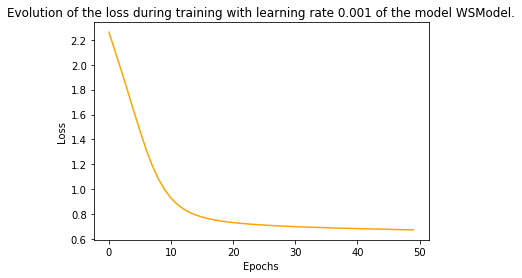

Loss at   0 : 0.6840568780899048  
Loss at   1 : 0.6556301712989807  
Loss at   2 : 0.6146690249443054  
Loss at   3 : 0.5187113285064697  
Loss at   4 : 0.45332837104797363  
Loss at   5 : 0.44279247522354126  
Loss at   6 : 0.39640235900878906  
Loss at   7 : 0.36747050285339355  
Loss at   8 : 0.3426870107650757  
Loss at   9 : 0.31561875343322754  
Loss at  10 : 0.2909930348396301  
Loss at  11 : 0.26062148809432983  
Loss at  12 : 0.23468321561813354  
Loss at  13 : 0.2074463814496994  
Loss at  14 : 0.18283385038375854  
Loss at  15 : 0.24421176314353943  
Loss at  16 : 0.18556994199752808  
Loss at  17 : 0.1437249630689621  
Loss at  18 : 0.1344972550868988  
Loss at  19 : 0.16849374771118164  
Loss at  20 : 0.10219716280698776  
Loss at  21 : 0.11019504815340042  
Loss at  22 : 0.10636652261018753  
Loss at  23 : 0.09226144850254059  
Loss at  24 : 0.07268428057432175  
Loss at  25 : 0.037711258977651596  
Loss at  26 : 0.03131801262497902  
Loss at  27 : 0.022281572222709656  

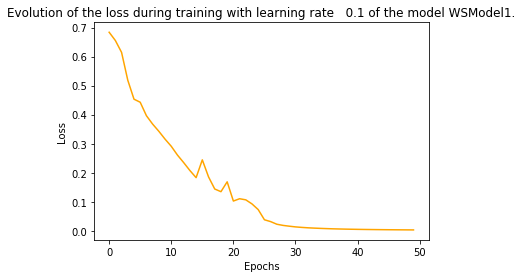

Loss at   0 : 0.687981128692627  
Loss at   1 : 0.6799423694610596  
Loss at   2 : 0.6735713481903076  
Loss at   3 : 0.6671436429023743  
Loss at   4 : 0.6611428260803223  
Loss at   5 : 0.6544535756111145  
Loss at   6 : 0.6470929980278015  
Loss at   7 : 0.6392145752906799  
Loss at   8 : 0.630715548992157  
Loss at   9 : 0.6212506890296936  
Loss at  10 : 0.6109781265258789  
Loss at  11 : 0.6003397703170776  
Loss at  12 : 0.5892383456230164  
Loss at  13 : 0.5777766704559326  
Loss at  14 : 0.5660536289215088  
Loss at  15 : 0.5541815757751465  
Loss at  16 : 0.5423587560653687  
Loss at  17 : 0.5307401418685913  
Loss at  18 : 0.5194678902626038  
Loss at  19 : 0.5086349248886108  
Loss at  20 : 0.49832430481910706  
Loss at  21 : 0.48861733078956604  
Loss at  22 : 0.4794454872608185  
Loss at  23 : 0.47078749537467957  
Loss at  24 : 0.46266213059425354  
Loss at  25 : 0.45508795976638794  
Loss at  26 : 0.44791802763938904  
Loss at  27 : 0.44105255603790283  
Loss at  28 : 0

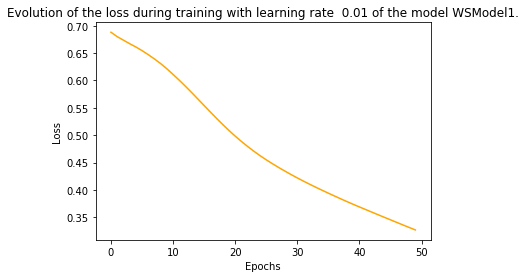

Loss at   0 : 0.6920891404151917  
Loss at   1 : 0.691874086856842  
Loss at   2 : 0.6917136907577515  
Loss at   3 : 0.691508412361145  
Loss at   4 : 0.6913018822669983  
Loss at   5 : 0.6911071538925171  
Loss at   6 : 0.6908904314041138  
Loss at   7 : 0.6906723976135254  
Loss at   8 : 0.6904453039169312  
Loss at   9 : 0.6902166604995728  
Loss at  10 : 0.6899752616882324  
Loss at  11 : 0.68970787525177  
Loss at  12 : 0.6894120573997498  
Loss at  13 : 0.6891146898269653  
Loss at  14 : 0.6888101100921631  
Loss at  15 : 0.6884899139404297  
Loss at  16 : 0.6881622076034546  
Loss at  17 : 0.6878094673156738  
Loss at  18 : 0.6874570250511169  
Loss at  19 : 0.6870743632316589  
Loss at  20 : 0.6866759657859802  
Loss at  21 : 0.6862579584121704  
Loss at  22 : 0.6858667135238647  
Loss at  23 : 0.6854825019836426  
Loss at  24 : 0.6850976347923279  
Loss at  25 : 0.6847012042999268  
Loss at  26 : 0.6842901706695557  
Loss at  27 : 0.6838645935058594  
Loss at  28 : 0.68343353

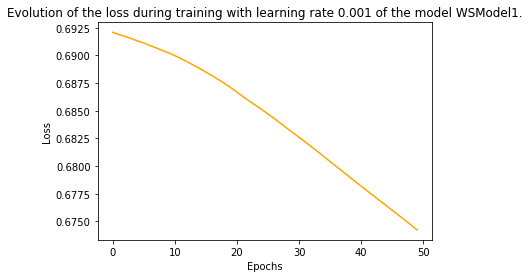

In [84]:
for j in range(len(models)):

    for i in range(len(learning_rates)):
        models = [WSModel(),WSModel1()]
        model = models[j]
        optimizer = op(model.parameters(),lr = learning_rates[i])
        loss_aux = train_model_WS(model, optimizer,  train_input, train_target, NB_EPOCHS, MINI_BATCH_SIZE,losses[0])
        print_results(model,op,learning_rates[i],NB_EPOCHS,MINI_BATCH_SIZE, train_input, train_target,test_input, test_target)
        visualize_loss(model,loss_aux,learning_rates[i])

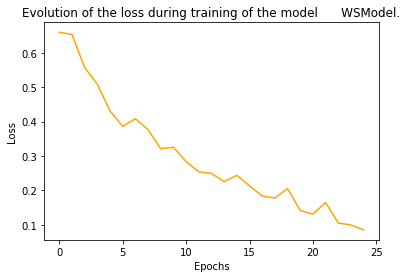

In [19]:
visualize_loss(model,loss_aux)

### Auxiliary Loss Model (Youssef)

In [20]:
import torch
from torchvision import datasets
from torch import optim
import dlc_practical_prologue as prologue
from AuxModel import *
from torch.autograd import Variable
from torch.nn import functional as F

In [27]:
model = AuxModel() ## Auxiliaryloss model with main architecture.

In [22]:
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rates[0])

#### Training of the AuxModel.

In [23]:
loss_aux = train_model_AM(model, optimizer,  train_input, train_target, train_classes,NB_EPOCHS,MINI_BATCH_SIZE)

Loss at   0 : 5.261308193206787  
Loss at   1 : 5.16166877746582  
Loss at   2 : 5.137136459350586  
Loss at   3 : 4.6822357177734375  
Loss at   4 : 4.441250801086426  
Loss at   5 : 4.446071624755859  
Loss at   6 : 3.907452344894409  
Loss at   7 : 4.025806427001953  
Loss at   8 : 3.222829818725586  
Loss at   9 : 2.569108486175537  
Loss at  10 : 2.358966827392578  
Loss at  11 : 1.9259467124938965  
Loss at  12 : 1.7242460250854492  
Loss at  13 : 1.6312466859817505  
Loss at  14 : 1.897026777267456  
Loss at  15 : 1.2340689897537231  
Loss at  16 : 1.9339656829833984  
Loss at  17 : 1.4165364503860474  
Loss at  18 : 1.3629921674728394  
Loss at  19 : 1.3215510845184326  
Loss at  20 : 1.282139778137207  
Loss at  21 : 1.242224097251892  
Loss at  22 : 1.2212860584259033  
Loss at  23 : 1.1891661882400513  
Loss at  24 : 1.0359306335449219  


#### Results on Training and Testing set.

In [24]:
print_results(model,op,learning_rates[0],NB_EPOCHS,MINI_BATCH_SIZE, train_input, train_target,test_input, test_target)

model:      AuxModel, optimizer:        SGD, learning rate:    0.1, num epochs:  25, mini batch size: 100, train error:  5.30%, test error:  9.10%


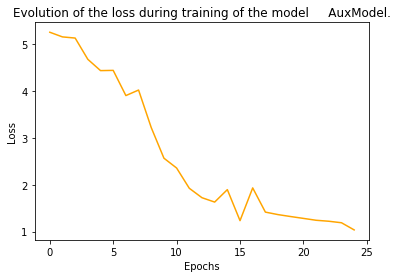

In [25]:
visualize_loss(model,loss_aux)

In [26]:
compute_nb_errors(model, test_input, test_target, mini_batch_size)

91